<h1 align=center>Final Tutorial - Relationship and Impacts of COVID on the Movie Industry</h1>
<h2 align=center>Venkat Gokaraju, Sean Tan, Tony Chen, Jahanzeb Hassan</h2>

COVID-19 has impacted the ways that many of us live our daily lives. In every aspect from the workplace to our home lives, many aspects have changed. However, one of the industry that was most heavily impacted by the coronavirus was the film and movie industry. As a result of many movies closing and the reliance that the film industry has on in-person "normal"-looking interaction for filming, they struggled to succeed during the pandemic. [ABC News](https://abcnews.go.com/US/covid-19-changed-movie-industry/story?id=78901700) wrote in July that "global theatric revenue in the U.S. fell from \$42.3 billion in 2019 to just \$12 billion in 2020". On the other hand, popular movie streaming platforms grew at a fast rate during the pandemic as many Americans yearned for entertainment as they were in lockdown. In a report by Fortune Business Insights, "a PWC analysis [found that] viewers' time spent streaming has grown by 75% by 2020." It goes on to say that "the number of subscriptions in the U.S. has grown to an astounding 125 million, and a similar trend is being observed internationally" (https://www.globenewswire.com/news-release/2021/12/15/2352238/0/en/Video-Streaming-Market-Share-to-Touch-USD-932-29-Billion-by-2028-Video-Streaming-Market-Size-2021-to-2028.html).  

However, we wanted to explore this further. How large of an impact did COVID have on the success of films? What did the growth of the movie industry look like before COVID, compared to during COVID? We wanted to find out more about the interactions between the movie industry and COVID.

<h2> Setup and Data Collection </h2>
Of course, we started with importing some libraries that would allow us to do analysis on our data.

In [18]:
import sqlite3 as sql, pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as pyplot, math
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import seaborn as sns
import datetime
import warnings

sns.set_theme(style="darkgrid")
#Ignore warning labels
warnings.filterwarnings('ignore')
matplotlib_axes_logger.setLevel('ERROR')

In order to begin analysis, we must first obtain data on the movie industry. We decided to focus on a very specific portion of data related to the movie industry - 

This data comes from [themoviedb.org](https://themoviedb.org). We selected movies fits the following criteria:

- Released between 2018 to 2021
- Released in United States, European Union, China, or Japan
- More than 100 people rated the movie
- Received a rating of more than 5
- Is at least 1 hour long

We got 550 movies for 2018, 604 movies for 2019, 463 movies for 2020, and 311 movies for 2021.

```sql
CREATE TABLE movies(
    id INTEGER PRIMARY KEY,
    title TEXT,
    release_date TEXT,
    adult BOOLEAN,
    popularity INTEGER,
    vote_average FLOAT,
    vote_count INTEGER,
    revenue INTEGER,
    budget INTEGER
)
```

In [2]:
movieDB = 'movie.db'
conn = sql.connect(movieDB)

# Queries movie.db for movie title, release date, popularity, vote average, vote count, revenue, and budget
sql_query = ''' \
    SELECT movies.title, movies.release_date, movies.popularity, movies.vote_average, movies.vote_count, movies.revenue, movies.budget
    FROM movies
'''

moviesDF = pd.read_sql(sql_query, conn)
moviesDF.head()


,title,release_date,popularity,vote_average,vote_count,revenue,budget
0,Bad Boys for Life,2020-01-17,73.253,7.2,6645,426505244,90000000
1,Super Troopers 2,2018-04-20,12.451,5.8,322,18850674,13500000
2,Pet Sematary,2019-04-05,24.863,5.7,2559,112399944,21000000
3,How to Train Your Dragon: The Hidden World,2019-02-22,61.609,7.8,4810,517526875,129000000
4,Star Wars: The Rise of Skywalker,2019-12-20,62.079,6.5,7223,1074144248,250000000


The parameters of interest to us include the movie title, its release date, voting average, voting count, revenue, and budget. 

<h2> Preparing/Tidying Data </h2>
To prepare the data for analysis, we will do the following: 

-Removing movies with 0's in any columns, as this generally indicates that the movies are unreleased.

-Creating a datetime column for the release date.

-Sorting by datetime in increasing order.

In [3]:
# Minor cleaning, remove movies with any 0s (generally these are unreleased movies)
moviesDF = moviesDF.loc[(moviesDF!=0).all(axis=1)]

# Adds datetime column.
datetimes = [datetime.datetime.strptime(x,'%Y-%m-%d') for x in moviesDF['release_date']]
moviesDF['datetime'] = datetimes

# Sorts by date in increasing order.
moviesDF.sort_values(by='datetime', inplace=True)

moviesDF.head()

,title,release_date,popularity,vote_average,vote_count,revenue,budget,datetime
152,Insidious: The Last Key,2018-01-05,34.260,6.2,2125,167184112,10000000,2018-01-05
484,Batman: Gotham by Gaslight,2018-01-12,18.401,6.7,509,3469151,1000000,2018-01-12
293,Proud Mary,2018-01-12,12.737,5.4,407,21753365,14000000,2018-01-12
120,The Commuter,2018-01-12,27.599,6.3,3554,119942387,30000000,2018-01-12
582,The Vegetable,2018-01-18,6.246,5.8,236,8475827,8166084,2018-01-18


<h2> Exploratory Data Analysis on Movie Data </h2>

Now that our data is ready for analysis, we will perform exploratory data analysis to understand basic characteristics of the data. We will do some exploratory analysis of the information on movies in general. We'll first do a linear regression model looking at the relationship between movie popularity and movie revenue. We will look at every movie in the movies (moviesDF) DataFrame.

<h3> Movie Popularity and Revenue </h3>

First, we will explore how the popularity and revenue of a movie are related. To do that, we will create a scatter plot showing Revenue vs. Popularity and superimpose a regression line.

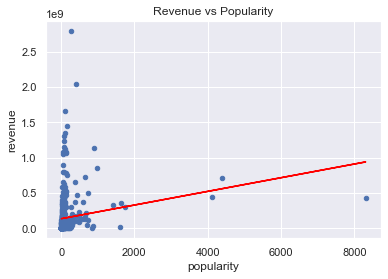

In [19]:
# Plot popularity against revenue
ax1 = moviesDF.plot.scatter(x='popularity', y='revenue')
ax1.set_title("Revenue vs Popularity")

# Linear regression on popularity and revenue
popularityCol = moviesDF['popularity']
revenueCol = moviesDF['revenue']

m, b = np.polyfit(popularityCol, revenueCol, deg=1)

# Plot regression line
ax1.plot(popularityCol, m*popularityCol + b, color='red')

pyplot.show()

This looks really ugly! The data here is very skewed towards low revenue, low popularity so we'll need to do a log transformation on the data to get a better visualization. Let's fixed that.

<h4> -- Log Transformation, note that interpretation of coefficients becomes %'s -- </h4>

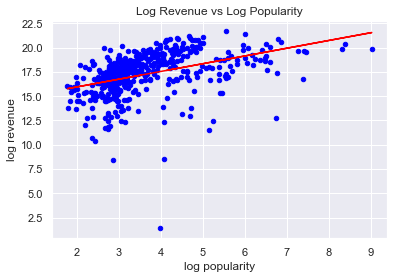

In [5]:
pd.options.mode.chained_assignment = None #Removes warning output text

popularityColLog = [np.log(x) for x in popularityCol]
revenueColLog = [np.log(x) for x in revenueCol]

moviesDF.loc[:, 'log popularity'] = popularityColLog
moviesDF.loc[:, 'log revenue'] = revenueColLog

#Puts popularity and revenue into scatter plot
ax2 = moviesDF.plot.scatter(x='log popularity', y='log revenue', color='blue')
ax2.set_title("Log Revenue vs Log Popularity")

popularityColLog = moviesDF.loc[:, 'log popularity']
revenueColLog = moviesDF.loc[:, 'log revenue']

#Gets regression line for popularity and revenue and plots it on to scatter plot
m, b = np.polyfit(popularityColLog, revenueColLog, deg=1)
ax2.plot(popularityColLog, m*popularityColLog + b, color='red')

pyplot.show()

From the scatter plot, we see a positive correlation between popularity and revenue. This means as popularity of a movie rises then its revenue will also rise. Most of the data is centered at around 2 - 5 log popularity with most revenue being above 12.5 log revenue. This result was expected since if a movie was popular then that means a lot of people wanted to see it and so they bought tickets to go see it at the movie theatre or streamed it on one of the movie streaming platforms that had the movie. This generates revenue for the movie.  

<h3> Movie Rating and Revenue </h3>

Now, we will analyze the relationship between a movie's rating and its revenue. We hypothesize that movies with higher ratings will tend to generate more revenue.

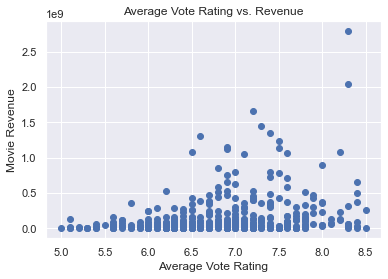

In [6]:
# Gets x and y variables.
x,y = moviesDF['vote_average'], moviesDF['revenue']

# Creates scatter plot.
pyplot.scatter(x, y)

# Sets plot labels.
pyplot.xlabel("Average Vote Rating")
pyplot.ylabel("Movie Revenue")
pyplot.title("Average Vote Rating vs. Revenue")

pyplot.show()

From the plot, we can see that movies with low ratings (<6) have low variance in their revenues and typically generate little revenue. Gradually, as the rating increases, the variation starts to increase. While most of the data points are concentrated near the bottom of the graph, there are several data points spread out near mear the middle of the graph. Finally, we see that the movies with the highest ratings have many outliers, with some movies generating $2B+ while others generating close to nothing.

<h3> Movie Budget and Revenue </h3>

We suspect that the budget of the movie might have a heavier influence on the total revenue than the movie's rating, so we are going to plot Budget vs. Movie Revenue to investigate this relationship. Because this data is very skewed, we are instead going to plot Log Budget vs. Log Movie Revenue to help us see the relationship better.

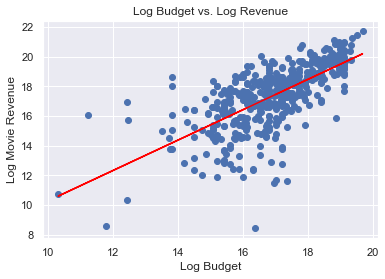

In [7]:
# Takes log of budget.
log_budget = [np.log(x) for x in moviesDF['budget']]
moviesDF['log budget'] = log_budget

# Filters data to exclude outlier.
x, y = moviesDF[moviesDF['log budget'] >= 10]['log budget'], moviesDF[moviesDF['log budget'] >= 10]['log revenue']

# Creates scatter plot.
pyplot.scatter(x, y)

# Plots linear regression line.
m, b = np.polyfit(x, y, deg=1)
pyplot.plot(x, m*x + b, color="red")

# Sets plot labels.
pyplot.xlabel("Log Budget")
pyplot.ylabel("Log Movie Revenue")
pyplot.title("Log Budget vs. Log Revenue")

pyplot.show()

In [8]:
# Calculates Pearson correlation coefficient. 
corr, _ = pearsonr(x, y)
print(f"Pearson correlation coefficient: {corr}")

Pearson correlation coefficient: 0.6723790834387935


Based on the plot, we can see a linear relationship between the budget and the movie revenue. The Pearson correlation coefficient tells us that the budget and the movie revenue are positively correlated and that the linear association between the two variables is fairly strong. This makes sense since if you spend/invest more then your return on investment (ROI) should theoretically be higher. 

<h3> Movie Data Over Time </h3>

Now, we are going to investigate how movie data has changed from 2018 to 2021 by plotting some violin plots.

First, we are going to create a year column.

In [9]:
# Extracts year from release date and creates a seperate 'year' column in the dataframe.
year = [x.split('-')[0] for x in moviesDF['release_date']]
moviesDF['year'] = year

moviesDF.head()

,title,release_date,popularity,vote_average,vote_count,revenue,budget,datetime,log popularity,log revenue,log budget,year
152,Insidious: The Last Key,2018-01-05,34.260,6.2,2125,167184112,10000000,2018-01-05,3.533978,18.934606,16.118096,2018
484,Batman: Gotham by Gaslight,2018-01-12,18.401,6.7,509,3469151,1000000,2018-01-12,2.912405,15.059420,13.815511,2018
293,Proud Mary,2018-01-12,12.737,5.4,407,21753365,14000000,2018-01-12,2.544511,16.895279,16.454568,2018
120,The Commuter,2018-01-12,27.599,6.3,3554,119942387,30000000,2018-01-12,3.317780,18.602522,17.216708,2018
582,The Vegetable,2018-01-18,6.246,5.8,236,8475827,8166084,2018-01-18,1.831941,15.952729,15.915500,2018


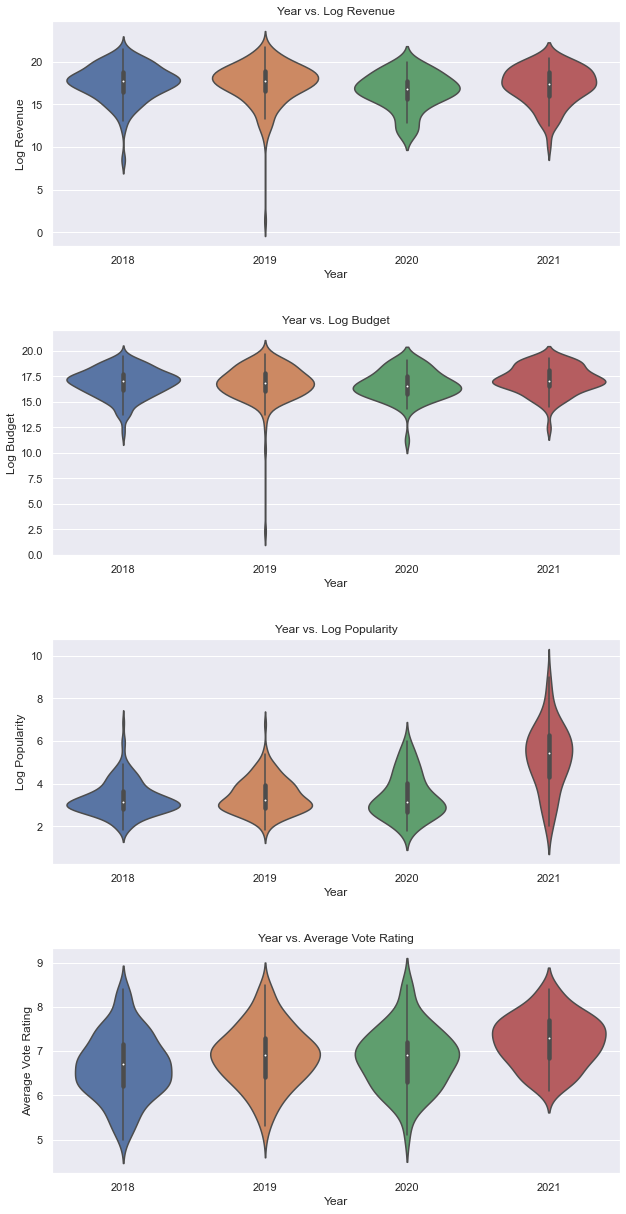

In [10]:
fig, axes = pyplot.subplots(4, 1, figsize=(10,18))
fig.tight_layout(pad=5)

# Revenue

# Creates violin plot.
sns.violinplot(x="year", y="log revenue", ax=axes[0], data=moviesDF)

# Sets plot labels.
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Log Revenue")
axes[0].set_title("Year vs. Log Revenue")


# Budget

# Creates violin plot.
sns.violinplot(x="year", y="log budget", ax=axes[1], data=moviesDF)

# Sets plot labels.
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Log Budget")
axes[1].set_title("Year vs. Log Budget")

# Popularity

# Creates violin plot.
sns.violinplot(x="year", y="log popularity", ax=axes[2], data=moviesDF)

# Sets plot labels.
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Log Popularity")
axes[2].set_title("Year vs. Log Popularity")


# Average Vote Rating

# Creates violin plot.
sns.violinplot(x="year", y="vote_average", ax=axes[3], data=moviesDF)

# Sets plot labels.
axes[3].set_xlabel("Year")
axes[3].set_ylabel("Average Vote Rating")
axes[3].set_title("Year vs. Average Vote Rating")

pyplot.show()

Based on the plots, there are not any noticeable changes over the years for the movie budget and the revenue. However, the movies' popularity has increased from 2020 to 2021. Also, we see that the ratings for the movies have increased slightly over the years.

<h2> Relating Movie Data to COVID-19 Data </h2>

<h3> Covid Dataset </h3>

Before we can analyze the COVID-19 data with respect to the movie data, we have to fetch the COVID-19 data and then integrate it into the movies data frame.

We will use the "Covid-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University" (https://github.com/CSSEGISandData/COVID-19) which contains Covid case numbers and deaths around the world between 2019 and the present day (as of writing this that would be December 2021). 

The parameters of interest to us include cumulative cases (or total number of covid cases since that day), daily new cases (number of cases found on that day), two week cases, cumulative deaths, and daily new deaths. 

<h3> Fetching Data </h3>

-- Pulling covid dataset, include information about source, reason to aggregate, etc etc --

-- Adding last 14 day cases count, and pre/post covid to movie df --

In [11]:
# Reads covid19 worldwide cases csv file
cases_COVID = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_COVID = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

# Aggregating data as we will focus on just aggregate information by date
cases_COVID.drop(columns=['Province/State','Country/Region', 'Lat', 'Long'], inplace=True)
deaths_COVID.drop(columns=['Province/State','Country/Region', 'Lat', 'Long'], inplace=True)

cumulative_cases = cases_COVID.sum(axis=0)
cumulative_deaths = deaths_COVID.sum(axis=0)

# Calculate daily new cases & deaths
daily_new_cases = cumulative_cases.copy()
daily_new_deaths = cumulative_deaths.copy()
two_week_cases = cumulative_cases.copy()

covid_DF = pd.concat([cumulative_cases, daily_new_cases, two_week_cases, cumulative_deaths, daily_new_deaths], axis=1)
covid_DF.columns = ['cumulative_cases', 'daily_new_cases', 'two_week_cases', 'cumulative_deaths', 'daily_new_deaths']

# Reset index for calculations
covid_DF.reset_index(inplace=True)

# Daily Cases/Deaths
for i in range(1, len(covid_DF)):
    covid_DF.loc[i,'daily_new_cases'] = covid_DF.loc[i,'cumulative_cases'] - covid_DF.loc[i-1,'cumulative_cases']
    covid_DF.loc[i,'daily_new_deaths'] = covid_DF.loc[i,'cumulative_deaths'] - covid_DF.loc[i-1,'cumulative_deaths']
covid_DF.loc[0,'daily_new_cases'] = covid_DF.loc[0,'cumulative_cases']
covid_DF.loc[0,'daily_new_deaths'] = covid_DF.loc[0,'cumulative_deaths']

# Two Week Cases
running_sum = 0
for i in range(0, 14):
    running_sum = running_sum + covid_DF.loc[i,'daily_new_cases']
    covid_DF.loc[i, 'two_week_cases'] = running_sum
for i in range(14, len(covid_DF)):
    running_sum = running_sum - covid_DF.loc[i-14, 'daily_new_cases'] + covid_DF.loc[i,'daily_new_cases']
    covid_DF.loc[i, 'two_week_cases'] = running_sum

covid_DF.set_index('index', inplace=True)
covid_DF.head()

,cumulative_cases,daily_new_cases,two_week_cases,cumulative_deaths,daily_new_deaths
index,,,,,
1/22/20,557,557,557,17,17
1/23/20,655,98,655,18,1
1/24/20,941,286,941,26,8
1/25/20,1434,493,1434,42,16
1/26/20,2118,684,2118,56,14


<h3> Combining COVID-19 and Movie Data </h3>

Here, we will extract revelant information from the COVID-19 table and add it to the movie data frame. We are joining the COVID-19 data on date and the movie data on release date

In [12]:
moviesDF.loc[:,'cumulative_cases'] = [0] * len(moviesDF)
moviesDF.loc[:,'daily_new_cases'] = [0] * len(moviesDF)
moviesDF.loc[:,'cumulative_deaths'] = [0] * len(moviesDF)
moviesDF.loc[:,'daily_new_deaths'] = [0] * len(moviesDF)
moviesDF.loc[:,'during_covid'] = [False] * len(moviesDF)

for i, row in moviesDF.iterrows():
    curr_date = row['release_date'].split('-')
    curr_date[0] = curr_date[0][len(curr_date[0])//2:]
    date = str(int(curr_date[1])) + '/' + curr_date[2] + '/' + curr_date[0]
    try:
        covid_row = covid_DF.loc[date]
        moviesDF.loc[i, 'cumulative_cases'] = covid_row.loc['cumulative_cases']
        moviesDF.loc[i, 'daily_new_cases'] = covid_row.loc['daily_new_cases']
        moviesDF.loc[i, 'cumulative_deaths'] = covid_row.loc['cumulative_deaths']
        moviesDF.loc[i, 'daily_new_deaths'] = covid_row.loc['daily_new_deaths']
        moviesDF.loc[i, 'during_covid'] = True
    except KeyError:
        pass

moviesDF.head()


,title,release_date,popularity,vote_average,vote_count,revenue,budget,datetime,log popularity,log revenue,log budget,year,cumulative_cases,daily_new_cases,cumulative_deaths,daily_new_deaths,during_covid
152,Insidious: The Last Key,2018-01-05,34.260,6.2,2125,167184112,10000000,2018-01-05,3.533978,18.934606,16.118096,2018,0,0,0,0,False
484,Batman: Gotham by Gaslight,2018-01-12,18.401,6.7,509,3469151,1000000,2018-01-12,2.912405,15.059420,13.815511,2018,0,0,0,0,False
293,Proud Mary,2018-01-12,12.737,5.4,407,21753365,14000000,2018-01-12,2.544511,16.895279,16.454568,2018,0,0,0,0,False
120,The Commuter,2018-01-12,27.599,6.3,3554,119942387,30000000,2018-01-12,3.317780,18.602522,17.216708,2018,0,0,0,0,False
582,The Vegetable,2018-01-18,6.246,5.8,236,8475827,8166084,2018-01-18,1.831941,15.952729,15.915500,2018,0,0,0,0,False


-- Advanced Regression Models --

<ul> 
    <li> Popularity vs. Cases </li>
    <li> Popularity vs. Death rates </li>
    <li> Revenue vs. Cases </li>
</ul>


In [13]:
#Get model for population by case
pop_by_case = smf.ols('popularity~cumulative_cases', data=moviesDF).fit()
pop_by_case.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     21.84
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           3.92e-06
Time:                        01:04:59   Log-Likelihood:                -3431.3
No. Observations:                 449   AIC:                             6867.
Df Residuals:                     447   BIC:                             6875.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           84.8673     25.585      3.317      0.001      34.585     135.149
cumulative_cases  1.877e-06   4.02e-07      4.674      0.000    1.09e-06    2.67e-06
==============================================================================
Omnibus:                      835.123   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           562099.474
Skew:                          11.964   Prob(JB):                         0.00
Kurtosis:                     174.677   Cond. No.                     6.83e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3> Revenue and Budget Before and After COVID-19 </h3>

Here, we will compare the revenue and budget of movies before and after COVID-19.

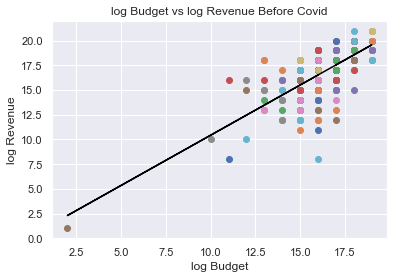

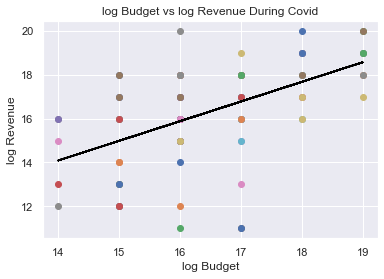

In [14]:
#Analyzing the relationship (if any) between revenue and budget before and after covid.

revenueDuringCovid = []
revenueBeforeCovid = []
budgetDuringCovid = []
budgetBeforeCovid = []

fig1, ax1 = pyplot.subplots() # revenue vs budget before covid scatter plot
fig2, ax2 = pyplot.subplots() # revenue vs budget during covoid scatter plot

#Plots revenue and budget data on to either the revenue vs budget before covid scatter plot or revenue vs budget
#during covid scatter plot. 
for i, row in moviesDF.iterrows():
    revenue = int(moviesDF.at[i, 'log revenue'])
    budget = int(moviesDF.at[i, 'log budget'])
    if moviesDF.at[i, 'during_covid']:
        revenueDuringCovid.append(revenue)
        budgetDuringCovid.append(budget)
        ax2.scatter(budget, revenue)
    else:
        revenueBeforeCovid.append(revenue)
        budgetBeforeCovid.append(budget)
        ax1.scatter(budget, revenue)


ax1.set_title("log Budget vs log Revenue Before Covid")
ax1.set_xlabel("log Budget")
ax1.set_ylabel("log Revenue")

ax2.set_title("log Budget vs log Revenue During Covid")
ax2.set_xlabel("log Budget")
ax2.set_ylabel("log Revenue")

budgetBeforeCovid, budgetDuringCovid = pd.Series(budgetBeforeCovid), pd.Series(budgetDuringCovid)

m1, b1 = np.polyfit(budgetBeforeCovid, revenueBeforeCovid, deg=1)
#Plot regression line for budget before covid vs revenue before Covid scatter plot
ax1.plot(budgetBeforeCovid, m1*budgetBeforeCovid + b1, color="black")

m2, b2 = np.polyfit(budgetDuringCovid, revenueDuringCovid, deg=1)
#Plot regression line for budget after covid vs revenue after Covid scatter plot
ax2.plot(budgetDuringCovid, m2*budgetDuringCovid + b2, color="black")


From the plot titled, "Budget vs Revenue Before Covid" we see a positive correlation between budget and revenue. This means that before Covid appeared, movies with larger budgets resulted in larger revenue. 

On the other hand, from the plot titled, "Budget vs Revenue During Covid" we don't see much of a correlation. Multiple data points are scattered throughout the plot and so it doesn't show a clear relationship between budget and revenue during Covid. This could indicate that Covid disrupted the movie industry and their revenue streams. 

We also see that budget and revenue is lower for movies during Covid in comparison to movies released before covid. This makes sense as lockdowns forced movie theatres to close down which negatively affects the sales of movies being released at that time. However, we do see some movies who have high revenues and this could possibly be due to the movies being released through movie streaming platforms which exploded in popularity during the pandemic. 

<h3> Movie Popularity and Daily New Cases </h3>

Here, we will investigate the relationship between movie popularity and daily new COVID-19 cases during the pandemic. We want to check out if there's a parallel or inverse relationship between popularity and daily new Covid-19 cases. 

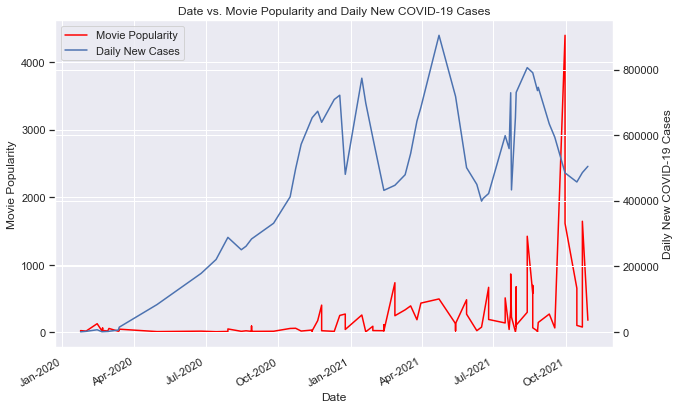

In [15]:
# Filters out data points that did not occur during the pandemic.
df = moviesDF[moviesDF['during_covid'] == True]

x, movie_y, covid_y = df['datetime'], df['popularity'], df['daily_new_cases']

fig, ax1 = pyplot.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Creates scatter plot.
p1 = ax1.plot(x, movie_y, color='red', label='Movie Popularity')
p2 = ax2.plot(x, covid_y, label='Daily New Cases')

# Creates legend.
plot1, label1 = ax1.get_legend_handles_labels()
plot2, label2 = ax2.get_legend_handles_labels()
ax2.legend(plot1 + plot2, label1 + label2, loc="upper left")

# Adjusts plot axes.

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
    
ax1.set_title("Date vs. Movie Popularity and Daily New COVID-19 Cases")
ax1.set_xlabel("Date")

ax1.set_ylabel("Movie Popularity")
ax2.set_ylabel("Daily New COVID-19 Cases")

pyplot.show()

The above scatter plot shows Date vs. Popularity and COVID-19 Cases using two y-axes. From the plot, we can see several spikes of daily new cases. The movie popularity seems to match the spikes slightly, but overall the movie popularity has a positive trend over time. The reason why there is not a significant relationship between COVID-19 cases and movie popularity is because the increase in movie popularity during the pandemic through streaming services may have offset the decrease in movie popularity as a result of movie theatres shutting down. Though, because there is a postive trend in the plot, the increase in movie popularity due to streaming services must have been more significant than the decrease in movie popularity due to movie theatres shutting down.

<h3> Log Standardized Popularity vs. Log Standardized Daily New Cases </h3>

Now, we will plot Log Standardized Popuarity vs. Log Standardized Daily New Cases to help us see if there is a relationship between the two variables. We first standardize the variables using the Z-score to make the variables more comparable. Next, we take the log of these variables to make the data less skewed. Because the Z-score can have values <= 0, we will add a constant 'c' before taking the log.

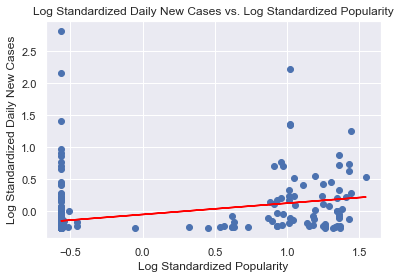

In [16]:
# Extracts appropriate columns.
popularity, daily_new_cases = moviesDF['popularity'], moviesDF['daily_new_cases']

# Standardizes columns using Z-score.
moviesDF['standardized popularity'] = (popularity - popularity.mean()) / popularity.std()
moviesDF['standardized daily new cases'] = (daily_new_cases - daily_new_cases.mean()) / daily_new_cases.std()

# Takes the log of Z-score.
c = 1
popularity_log = [np.log(x + c) for x in moviesDF['standardized popularity']]
cases_log = [np.log(x + c) for x in moviesDF['standardized daily new cases']]

# Gets x and y variables to plot.
x, y = pd.Series(cases_log), pd.Series(popularity_log)

# Creates scatter plot.
fig1, ax1 = pyplot.subplots()
ax1.scatter(x, y)

# Creates linear regression line.
m, b = np.polyfit(x, y, deg=1)
pyplot.plot(x, m*x + b, color="red")

# Adjusts plot axes.
ax1.set_title("Log Standardized Daily New Cases vs. Log Standardized Popularity")
ax1.set_xlabel("Log Standardized Popularity")
ax1.set_ylabel("Log Standardized Daily New Cases")

pyplot.show()

In [17]:
# Calculates Pearson correlation coefficient. 
corr, _ = pearsonr(x, y)
print(f"Pearson correlation coefficient: {corr}")

Pearson correlation coefficient: 0.33979066882094233


Looking at the plot, there is a slight positive correlation between popularity and daily new cases, which we also observed in the previous plot. As we stated earlier, the reason why the correlation is positive and fairly weak is because the increase in movie popularity during the pandemic through streaming services which may have offset the decrease in movie popularity as a result of movie theatres shutting down. However, the increase in movie popularity during the pandemic through streaming services may have been more significant, which is why the correlation is positive. 

<h2> Conclusion </h2> 

In summary, before looking at Covid data we looked at average movie rating, budget, and popularity and analyzed each of them to see if there was any relationship between it and movie revenue. We used linear regression to look at the relationship between movie budget and movie revenue and at the relationship between movie popularity and movie revenue. For both of these parameters we did find a positive correlation which suggests that there is a relationship. For average movie rating, we used a violin plot to analyze the relationship between it and movie revenue. The relationship presented by the plot wasn't as clear as the linear regression plots. We do see an increase in revenue as average movie rating increases. However, at the same time, the variance increases as average movie rating increases and we see some outliers. 

We then took a look at the effects Covid-19 had on the movie industry and the results were more or less expected. We first compared the relationship between budget and revenue before and after covid. We found a positive correlation between budget and revenue before Covid but not for one after Covid. This could suggest that the movie industry was disrupted by the pandemic. Throughout most of 2020, countries ordered lockdowns and closed commerical businesses that weren't considered non-essential and this included movie theatres. This is most likely the reason our regression plot for revenue vs budget after Covid had data points that didn't show uniformity like the regression plot for revenue vs budget before Covid. 

After that, we compared the trend between movie popularity with Covid-19 cases using a line plot. What's interesting here is that movie popularity increased at the beginning of 2021. This could be due to the rising popularity of watching movies on movie streaming services like Netfix, Disney+, Hulu, etc. Since people couldn't go to movie theatres due to lockdowns and/or avoiding crowds of people due to the ongoing pandemic, they chose to subscribe to movie streaming services to watch new movie releases and to stay entertained. There could also be other confounding factors that could be affecting the trend presented in the line plot and this is something we will look at in our future research. 

Lastly, we looked at the relationship between daily new cases and standardized popularity. We calculated the Pearson correlation coefficient to do this and the coefficient we got was very low (~0.34) which suggests that the relationship was very weak. 

After all that analysis, we found that the movie industy was in fact impacted by Covid 19. 


<h2> Future Research </h2>

We were very happy at the results we came to in our research and we would like to expand our research to other industries to see how their revenues were affected. We are interested to see if there were other industries that were resillient against the effects of the pandemic and which industries were not so lucky. 


